好的，這是一個使用 PyTorch 訓練 Autoencoder 的 Jupyter Notebook 範本。它包含了您要求的步驟：載入 CSV、分離 Benign/Non-Benign 流量、分割資料集、訓練 Autoencoder、以及在測試集（包含 Benign 和 Non-Benign 流量）上進行評估。

請將以下程式碼區塊複製到您的 Jupyter Notebook 的不同儲存格 (Cell) 中。

In [ ]:
# Install AWS-CLI
!curl "https://awscli.amazonaws.com/awscli-exe-linux-x86_64.zip" -o "awscliv2.zip"
!unzip awscliv2.zip
!sudo ./aws/install
!sudo rm ./awscliv2.zip

# Download CSV
!aws s3 sync --no-sign-request --region ap-east-1 "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/" ./cicddos2018

In [1]:
# ==================================================
# Cell 1: 匯入必要的函式庫與基本設定
# ==================================================
import torch                                    # PyTorch 核心函式庫
import torch.nn as nn                           # 神經網路模組
import torch.optim as optim                     # 優化器模組
from torch.utils.data import Dataset, DataLoader # 資料集與資料載入器工具
import pandas as pd                             # 資料處理函式庫
import numpy as np                              # 數值計算函式庫
from sklearn.model_selection import train_test_split # 資料分割工具
from sklearn.preprocessing import StandardScaler   # 資料標準化工具
import os                                       # 操作系統相關功能 (檔案路徑等)
import glob                                     # 查找符合特定規則的檔案路徑名
import gc                                       # 垃圾回收，用於手動釋放記憶體 (選項)

# --- 基本設定 ---
# 設定隨機種子以確保結果可重現
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# 檢查是否有可用的 GPU，若有則使用 GPU，否則使用 CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"將使用的設備: {device}")

# --- 記憶體優化選項 ---
# 是否在讀取 CSV 時嘗試降低記憶體佔用 (將數值類型降級)
downcast_numeric = True # 設定為 True 以啟用，False 則禁用
# 是否在處理大型 DataFrame 後手動觸發垃圾回收
manual_garbage_collection = False # 設定為 True 以啟用

print(f"啟用數值類型降級 (記憶體優化): {downcast_numeric}")
print(f"啟用手動垃圾回收 (記憶體優化): {manual_garbage_collection}")

將使用的設備: cuda
啟用數值類型降級 (記憶體優化): True
啟用手動垃圾回收 (記憶體優化): False


In [ ]:
# ==================================================
# Cell 2: 設定檔案路徑、標籤和特徵欄位
# ==================================================

# --- 輸入設定 ---
# 設定包含原始 CSV 檔案的資料夾路徑
# 請將 'path/to/your/csv/files' 替換成您存放 CSV 的實際路徑
# 假設您的 CSV 檔案名稱格式類似 'day1.csv', 'day2.csv', ...
input_csv_folder = '/home/jinting/桌面/data/cicddos-2018/All-CSV-By-CICFlowMeter'

# 設定輸出的資料夾路徑，用於存放處理後的 CSV 檔案
# 請將 'path/to/your/output/folder' 替換成您想要存放輸出檔案的路徑
output_folder = '/home/jinting/桌面/data/cicddos-2018/output'

# 設定 CSV 檔案中表示標籤的欄位名稱
label_column = 'Label' # 請依您的 CSV 檔案修改

# 設定代表 "正常" 流量的標籤值
benign_label_value = 'Benign' # 請依您的 CSV 檔案修改

# --- 特徵選擇 ---
# *** 請在此處設定您要用來訓練 Autoencoder 的特徵欄位名稱列表 ***
# 範例: features_to_use = ['Feature1', 'Feature3', 'Feature10', ...]
# 注意：請確保這些欄位都是數值類型，或在後續步驟中進行了適當的轉換
features_to_use = [
    # --- 請將上面替換成您實際要使用的特徵欄位 ---
    'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts',
    'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
    'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Std', 'Flow Byts/s',
    'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
    'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Tot', 'Bwd IAT Mean',
    'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
    'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min',
    'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
    'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt',
    'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
    'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg',
    'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Init Fwd Win Byts',
    'Init Bwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
    'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min'
]

# --- 建立輸出資料夾 ---
# 如果輸出資料夾不存在，則建立它
os.makedirs(output_folder, exist_ok=True)
print(f"輸入 CSV 資料夾: {input_csv_folder}")
print(f"輸出資料夾: {output_folder}")
print(f"標籤欄位: {label_column}")
print(f"正常流量標籤: {benign_label_value}")
print(f"將使用的特徵數量: {len(features_to_use)}")
# print(f"將使用的特徵: {features_to_use}") # 如果特徵很多，可以取消註解這行來查看

輸入 CSV 資料夾: /home/jinting/桌面/data/cicddos-2018/All-CSV-By-CICFlowMeter
輸出資料夾: /home/jinting/桌面/data/cicddos-2018/output
標籤欄位: Label
正常流量標籤: Benign
將使用的特徵數量: 78


In [ ]:
# ==================================================
# Cell 3: 載入、分離並儲存資料
# ==================================================
print("開始處理 CSV 檔案...")

# 找到所有符合模式的 CSV 檔案
# 假設您的 CSV 檔案都以 '.csv' 結尾
all_csv_files = glob.glob(os.path.join(input_csv_folder, '*.csv'))
print(f"找到 {len(all_csv_files)} 個 CSV 檔案。")

# 用於儲存所有 Benign 流量的 DataFrame 列表
benign_dfs = []

# 處理非數值或無限大值 (Infinity) 的函數
def clean_data(df, features):
    # 僅處理指定的特徵欄位
    df_subset = df[features].copy()
    # 將無限大值替換為 NaN
    df_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 填充 NaN 值 (例如用 0 或中位數/平均數，這裡用 0)
    # 考慮更進階的填充策略，例如使用該欄位的中位數
    # for col in features:
    #     if df_subset[col].isnull().any():
    #         median_val = df_subset[col].median()
    #         df_subset[col].fillna(median_val, inplace=True)
    df_subset.fillna(0, inplace=True)
    # 確保所有特徵欄位都是數值類型
    for col in features:
        df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce') # 無法轉換的變 NaN
    df_subset.fillna(0, inplace=True) # 再次填充可能由 to_numeric 產生的 NaN
    # 將清理後的數據合併回原始 DataFrame (保留標籤等其他列)
    df[features] = df_subset
    return df

# 迭代處理每個 CSV 檔案
for csv_file in all_csv_files:
    print(f"  正在處理檔案: {os.path.basename(csv_file)}")
    try:
        # 讀取 CSV 檔案
        # 記憶體優化：如果檔案很大，可以考慮分塊讀取 chunksize=...
        # df = pd.read_csv(csv_file, chunksize=100000) # 範例：每次讀取 10 萬行
        # for chunk in df:
        #    # 在這裡處理 chunk...
        df = pd.read_csv(csv_file)

        # 記憶體優化：降低數值類型精度 (若啟用)
        if downcast_numeric:
            for col in df.select_dtypes(include=['int64']).columns:
                df[col] = pd.to_numeric(df[col], downcast='integer')
            for col in df.select_dtypes(include=['float64']).columns:
                df[col] = pd.to_numeric(df[col], downcast='float')

        # --- 清理數據 ---
        # 確保標籤欄位存在
        if label_column not in df.columns:
            print(f"    警告: 檔案 {os.path.basename(csv_file)} 中找不到標籤欄位 '{label_column}'，跳過此檔案。")
            continue
        # 確保所有要使用的特徵欄位都存在
        missing_features = [f for f in features_to_use if f not in df.columns]
        if missing_features:
            print(f"    警告: 檔案 {os.path.basename(csv_file)} 中缺少以下特徵: {missing_features}，跳過此檔案。")
            continue

        # 清理特徵欄位中的非數值和無限大值
        df = clean_data(df, features_to_use)

        # 分離 Benign 和 Non-Benign 流量
        benign_data = df[df[label_column] == benign_label_value].copy()
        non_benign_data = df[df[label_column] != benign_label_value].copy()

        # 將 Benign 流量添加到列表中
        if not benign_data.empty:
            benign_dfs.append(benign_data)
            print(f"    找到 {len(benign_data)} 筆 Benign 流量。")
        else:
            print(f"    未找到 Benign 流量。")

        # 儲存 Non-Benign 流量 (依照原始檔名)
        if not non_benign_data.empty:
            output_filename = os.path.join(output_folder, f"non_benign_{os.path.basename(csv_file)}")
            non_benign_data.to_csv(output_filename, index=False)
            print(f"    儲存 {len(non_benign_data)} 筆 Non-Benign 流量到: {output_filename}")
        else:
            print(f"    未找到 Non-Benign 流量。")

        # 記憶體優化：刪除已處理的 DataFrame 並觸發垃圾回收 (若啟用)
        del df, benign_data, non_benign_data
        if manual_garbage_collection:
            gc.collect()

    except Exception as e:
        print(f"    處理檔案 {os.path.basename(csv_file)} 時發生錯誤: {e}")

# 合併所有 Benign 流量
if benign_dfs:
    all_benign_data = pd.concat(benign_dfs, ignore_index=True)
    benign_output_filename = os.path.join(output_folder, "benign_traffic_combined.csv")
    all_benign_data.to_csv(benign_output_filename, index=False)
    print(f"\n已合併所有 Benign 流量 ({len(all_benign_data)} 筆) 並儲存到: {benign_output_filename}")

    # 記憶體優化
    del benign_dfs, all_benign_data
    if manual_garbage_collection:
        gc.collect()
else:
    print("\n警告：未找到任何 Benign 流量，無法進行後續訓練。")

print("CSV 檔案處理完成。")

In [3]:
# ========================================
#   Cell 3 Function_如果不執行上面的函數的話
#   這一個一定要執行
# ========================================
# 處理非數值或無限大值 (Infinity) 的函數
def clean_data(df, features):
    # 僅處理指定的特徵欄位
    df_subset = df[features].copy()
    # 將無限大值替換為 NaN
    df_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
    # 填充 NaN 值 (例如用 0 或中位數/平均數，這裡用 0)
    # 考慮更進階的填充策略，例如使用該欄位的中位數
    # for col in features:
    #     if df_subset[col].isnull().any():
    #         median_val = df_subset[col].median()
    #         df_subset[col].fillna(median_val, inplace=True)
    df_subset.fillna(0, inplace=True)
    # 確保所有特徵欄位都是數值類型
    for col in features:
        df_subset[col] = pd.to_numeric(df_subset[col], errors='coerce') # 無法轉換的變 NaN
    df_subset.fillna(0, inplace=True) # 再次填充可能由 to_numeric 產生的 NaN
    # 將清理後的數據合併回原始 DataFrame (保留標籤等其他列)
    df[features] = df_subset
    return df

In [ ]:
# ==================================================
# Cell 4 (修改版 - 分塊處理)
# ==================================================
import time # 用於計時

print("準備 Benign 資料 (分塊處理)...")
benign_data_path = os.path.join(output_folder, "benign_traffic_combined.csv")

# 檢查合併後的 Benign 檔案是否存在
if not os.path.exists(benign_data_path):
    print(f"錯誤：找不到合併後的 Benign 資料檔案: {benign_data_path}")
    # raise FileNotFoundError(f"找不到檔案: {benign_data_path}")
else:
    # --- 步驟 1: 分塊計算標準化所需的統計量 (Mean & Variance) ---
    print("步驟 1: 分塊計算標準化統計量...")
    scaler = StandardScaler() # 初始化 Scaler
    chunksize = 2500000  # *** 設定每個區塊的大小 (可調整) ***
                        # 根據您的記憶體調整，例如 50000, 100000, 500000
    start_time = time.time()
    try:
        # 使用迭代器讀取 CSV 塊
        for i, chunk in enumerate(pd.read_csv(benign_data_path, chunksize=chunksize)):
            print(f"  處理塊 {i+1}...", end='\r') # \r 讓訊息在同一行更新

            # 記憶體優化：降低數值類型精度 (若啟用)
            if downcast_numeric:
                for col in chunk.select_dtypes(include=['int64']).columns:
                    chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
                for col in chunk.select_dtypes(include=['float64']).columns:
                    chunk[col] = pd.to_numeric(chunk[col], downcast='float')

            # 清理數據 (確保特徵存在且為數值)
            missing_features = [f for f in features_to_use if f not in chunk.columns]
            if missing_features:
                print(f"\n    警告: 塊 {i+1} 中缺少特徵: {missing_features}，跳過此塊的 Scaler Fit。")
                continue
            chunk = clean_data(chunk, features_to_use) # 使用 Cell 3 定義的 clean_data

            # 選取特徵
            chunk_features = chunk[features_to_use]

            # 使用 partial_fit 逐步計算統計量
            # 注意: partial_fit 假設數據分佈不隨時間劇烈變化
            scaler.partial_fit(chunk_features)

            # 記憶體優化
            del chunk, chunk_features
            if manual_garbage_collection:
                gc.collect()
        print(f"\n步驟 1 完成. 耗時: {time.time() - start_time:.2f} 秒")
        print(f"  Scaler 平均值 (部分範例): {scaler.mean_[:5]}") # 打印部分均值檢查
        print(f"  Scaler 標準差 (部分範例): {np.sqrt(scaler.var_[:5])}") # 打印部分標準差檢查

    except Exception as e:
        print(f"\n處理標準化統計量時發生錯誤: {e}")
        raise # 重新拋出錯誤，終止執行

    # --- 步驟 2: 分塊進行數據標準化、轉換為 Tensor 並收集 ---
    print("\n步驟 2: 分塊標準化數據並轉換為 Tensor...")
    all_scaled_tensors = [] # 用於收集每個塊的 Tensor
    total_rows = 0
    start_time = time.time()
    try:
        # 再次迭代讀取 CSV 塊
        for i, chunk in enumerate(pd.read_csv(benign_data_path, chunksize=chunksize)):
            print(f"  處理塊 {i+1}...", end='\r')

            # 記憶體優化：降低數值類型精度 (若啟用)
            if downcast_numeric:
                for col in chunk.select_dtypes(include=['int64']).columns:
                    chunk[col] = pd.to_numeric(chunk[col], downcast='integer')
                for col in chunk.select_dtypes(include=['float64']).columns:
                    chunk[col] = pd.to_numeric(chunk[col], downcast='float')

            # 清理數據
            missing_features = [f for f in features_to_use if f not in chunk.columns]
            if missing_features:
                print(f"\n    警告: 塊 {i+1} 中缺少特徵: {missing_features}，跳過此塊的轉換。")
                continue
            chunk = clean_data(chunk, features_to_use)

            # 選取特徵
            chunk_features = chunk[features_to_use]
            current_rows = len(chunk_features)
            total_rows += current_rows

            # 使用已經 fit 好的 scaler 進行 transform
            scaled_chunk_features = scaler.transform(chunk_features)

            # 轉換為 PyTorch Tensor (直接轉為 float32)
            chunk_tensor = torch.tensor(scaled_chunk_features, dtype=torch.float32)
            all_scaled_tensors.append(chunk_tensor)

            # 記憶體優化
            del chunk, chunk_features, scaled_chunk_features, chunk_tensor
            if manual_garbage_collection:
                gc.collect()
        print(f"\n步驟 2 完成. 耗時: {time.time() - start_time:.2f} 秒")

        # 將所有塊的 Tensor 合併成一個大的 Tensor
        if all_scaled_tensors:
            print("合併所有 Tensor 塊...")
            start_time = time.time()
            # 檢查是否有空的 Tensor (雖然前面有跳過，但以防萬一)
            all_scaled_tensors = [t for t in all_scaled_tensors if t.shape[0] > 0]
            if all_scaled_tensors:
                scaled_benign_features_tensor = torch.cat(all_scaled_tensors, dim=0)
                print(f"合併完成. 最終 Tensor 大小: {scaled_benign_features_tensor.shape}. 耗時: {time.time() - start_time:.2f} 秒")
                print(f"  總處理行數: {total_rows}")

                # 記憶體優化：刪除列表
                del all_scaled_tensors
                if manual_garbage_collection:
                    gc.collect()

                # --- 步驟 3: 分割訓練集與測試集 (在 Tensor 上操作) ---
                print("\n步驟 3: 分割訓練集與測試集...")
                start_time = time.time()
                # 直接分割 Tensor
                # 注意：如果 Tensor 非常大，這裡仍然可能需要大量記憶體來創建分割後的 Tensor
                # 但至少比同時持有 Pandas DF, NumPy Array 和 Tensor 要好
                try:
                    train_size = int(0.8 * len(scaled_benign_features_tensor))
                    test_size = len(scaled_benign_features_tensor) - train_size
                    # 使用 torch.utils.data.random_split 更安全且常用
                    train_dataset_full, test_dataset_full = torch.utils.data.random_split(
                        scaled_benign_features_tensor,
                        [train_size, test_size],
                        generator=torch.Generator().manual_seed(seed) # 確保分割可重現
                    )

                    # 我們需要的是 Tensor 本身，而不是 Dataset 對象
                    # 從 Dataset 中獲取索引，然後索引原始 Tensor
                    # 或者，如果記憶體允許，直接轉換
                    X_train_tensor = scaled_benign_features_tensor[train_dataset_full.indices]
                    X_test_benign_tensor = scaled_benign_features_tensor[test_dataset_full.indices]
                    # # 或者，如果您確認記憶體足夠，可以直接用 sklearn 的 train_test_split
                    # # 先將 Tensor 轉回 NumPy (這會消耗記憶體!)
                    # scaled_benign_features_np = scaled_benign_features_tensor.numpy()
                    # X_train_np, X_test_benign_np = train_test_split(
                    #     scaled_benign_features_np,
                    #     test_size=0.2,
                    #     random_state=seed
                    # )
                    # X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
                    # X_test_benign_tensor = torch.tensor(X_test_benign_np, dtype=torch.float32)
                    # del scaled_benign_features_np, X_train_np, X_test_benign_np
                    # if manual_garbage_collection: gc.collect()


                    print(f"分割完成. 耗時: {time.time() - start_time:.2f} 秒")
                    print(f"  訓練集 Tensor (X_train_tensor) 大小: {X_train_tensor.shape}")
                    print(f"  測試集 Tensor (X_test_benign_tensor) 大小: {X_test_benign_tensor.shape}")

                    # 記憶體優化
                    del scaled_benign_features_tensor, train_dataset_full, test_dataset_full
                    if manual_garbage_collection:
                        gc.collect()

                except Exception as e:
                    print(f"\n分割 Tensor 時發生錯誤: {e}")
                    print("這可能表示即使分塊載入，最終合併的 Tensor 對於分割操作來說仍然太大。")
                    print("可以考慮：")
                    print("1. 減小訓練數據的比例 (例如 test_size=0.5)。")
                    print("2. 只使用部分數據進行訓練 (數據抽樣)。")
                    print("3. 使用更專業的大數據工具 (如 Dask-ML)。")
                    raise
            else:
                print("錯誤：沒有有效的 Tensor 塊可以合併。")

        else:
            print("錯誤：未能成功收集任何標準化後的 Tensor 數據塊。")

    except Exception as e:
        print(f"\n處理數據標準化或 Tensor 轉換時發生錯誤: {e}")
        raise

準備 Benign 資料 (分塊處理)...
步驟 1: 分塊計算標準化統計量...


/tmp/ipykernel_62650/533132081.py:22: DtypeWarning: Columns (80,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(benign_data_path, chunksize=chunksize)):


/tmp/ipykernel_62650/533132081.py:22: DtypeWarning: Columns (80,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(benign_data_path, chunksize=chunksize)):


  處理塊 6...
步驟 1 完成. 耗時: 92.62 秒
  Scaler 平均值 (部分範例): [9.27247360e+00 0.00000000e+00 1.34534624e+07 6.05186245e+00
 7.16996230e+00]
  Scaler 標準差 (部分範例): [5.20303639e+00 0.00000000e+00 5.41971897e+08 7.64055631e+01
 1.79836275e+02]

步驟 2: 分塊標準化數據並轉換為 Tensor...


/tmp/ipykernel_62650/533132081.py:65: DtypeWarning: Columns (80,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(benign_data_path, chunksize=chunksize)):


/tmp/ipykernel_62650/533132081.py:65: DtypeWarning: Columns (80,81,83) have mixed types. Specify dtype option on import or set low_memory=False.
  for i, chunk in enumerate(pd.read_csv(benign_data_path, chunksize=chunksize)):


  處理塊 6...
步驟 2 完成. 耗時: 87.39 秒
合併所有 Tensor 塊...
合併完成. 最終 Tensor 大小: torch.Size([13484708, 78]). 耗時: 0.41 秒
  總處理行數: 13484708

步驟 3: 分割訓練集與測試集...
分割完成. 耗時: 2.70 秒
  訓練集 Tensor (X_train_tensor) 大小: torch.Size([10787766, 78])
  測試集 Tensor (X_test_benign_tensor) 大小: torch.Size([2696942, 78])


In [5]:
# ==================================================
# Cell 5: 建立 PyTorch Dataset 和 DataLoader
# ==================================================

# --- 自訂 PyTorch Dataset ---
# 建立一個簡單的 Dataset 類別，用於包裝我們的 Tensor 資料
class TrafficDataset(Dataset):
    # 初始化函數，接收資料 Tensor
    def __init__(self, data):
        self.data = data

    # 必須實現的方法：返回資料集的總長度
    def __len__(self):
        return len(self.data)

    # 必須實現的方法：根據索引 idx 返回一筆資料
    def __getitem__(self, idx):
        return self.data[idx], self.data[idx] # Autoencoder 的目標是重建物件本身

# --- 建立 DataLoader ---
# 設定批次大小 (Batch Size)
# 可以根據您的記憶體大小調整，較大的批次通常訓練較快，但需要更多記憶體
batch_size = 8192 # 可調整參數

# 建立訓練集的 DataLoader
# shuffle=True 表示在每個 epoch 開始時打亂訓練數據的順序，有助於模型學習
train_dataset = TrafficDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"訓練 DataLoader 已建立，批次大小: {batch_size}")

# 建立 Benign 測試集的 DataLoader
# shuffle=False 表示不打亂測試數據順序，評估時通常不需要打亂
test_benign_dataset = TrafficDataset(X_test_benign_tensor)
test_benign_loader = DataLoader(test_benign_dataset, batch_size=batch_size, shuffle=False)
print(f"Benign 測試 DataLoader 已建立，批次大小: {batch_size}")

# 記憶體優化
del X_train_tensor, X_test_benign_tensor, train_dataset, test_benign_dataset
if manual_garbage_collection:
    gc.collect()

訓練 DataLoader 已建立，批次大小: 8192
Benign 測試 DataLoader 已建立，批次大小: 8192


In [6]:
# ==================================================
# Cell 6: 定義 Autoencoder 模型架構
# ==================================================

# --- Autoencoder 模型 ---
class Autoencoder(nn.Module):
    # 初始化函數
    def __init__(self, input_dim, encoding_dim1, encoding_dim2, latent_dim):
        super(Autoencoder, self).__init__() # 呼叫父類別的初始化函數

        # --- 編碼器 (Encoder) ---
        # 定義編碼器的網路層
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim1), # 第一個線性層：輸入維度 -> 編碼維度1
            nn.Tanh(),                          # Tanh 激活函數，增加非線性
            nn.Linear(encoding_dim1, encoding_dim2),# 第二個線性層：編碼維度1 -> 編碼維度2
            nn.Sigmoid(),                          # Sigmod 激活函數
            nn.Linear(encoding_dim2, latent_dim), # 第三個線性層：編碼維度2 -> 潛在空間維度
            # 通常在最後一層編碼後不加激活函數，或根據需求選擇 (如 Tanh)
            # nn.Tanh() # 例如使用 Tanh 將潛在表示限制在 [-1, 1]
        )

        # --- 解碼器 (Decoder) ---
        # 定義解碼器的網路層，結構通常與編碼器對稱
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, encoding_dim2),    # 第一個線性層：潛在空間維度 -> 編碼維度2
            nn.Sigmoid(),                              # Sigmoid 激活函數
            nn.Linear(encoding_dim2, encoding_dim1), # 第二個線性層：編碼維度2 -> 編碼維度1
            nn.Tanh(),                              # Tanh 激活函數
            nn.Linear(encoding_dim1, input_dim),     # 第三個線性層：編碼維度1 -> 原始輸入維度
            # 最後一層通常不加激活函數，或使用 Sigmoid (如果輸入被縮放到 [0, 1])
            # nn.Sigmoid() # 如果輸入數據被標準化到 [0, 1] 區間
        )

    # 定義前向傳播函數
    def forward(self, x):
        encoded = self.encoder(x) # 輸入數據通過編碼器得到潛在表示
        decoded = self.decoder(encoded) # 潛在表示通過解碼器得到重建數據
        return decoded # 返回重建後的數據

# --- 模型參數設定 ---
# 獲取輸入特徵的維度
input_dim = len(features_to_use)

# *** 設定 Autoencoder 的隱藏層和潛在空間維度 (可調整) ***
# 這些參數決定了模型的容量和壓縮程度
encoding_dim1 = 78  # 第一層編碼/解碼的維度 (先設定成 Feature 長度)
encoding_dim2 = 39  # 第二層編碼/解碼的維度
latent_dim = 16     # 最終潛在空間的維度 (瓶頸層)

# 建立 Autoencoder 模型實例
model = Autoencoder(input_dim, encoding_dim1, encoding_dim2, latent_dim)

# 將模型移動到指定的設備 (CPU 或 GPU)
model.to(device)

# 打印模型架構
print("Autoencoder 模型架構:")
print(model)
print(f"\n模型輸入維度: {input_dim}")
print(f"模型潛在空間維度 (Latent Dim): {latent_dim}")

Autoencoder 模型架構:
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=78, out_features=78, bias=True)
    (1): Tanh()
    (2): Linear(in_features=78, out_features=39, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=39, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=39, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=39, out_features=78, bias=True)
    (3): Tanh()
    (4): Linear(in_features=78, out_features=78, bias=True)
  )
)

模型輸入維度: 78
模型潛在空間維度 (Latent Dim): 16


In [7]:
# ==================================================
# Cell 7: 設定訓練參數 (損失函數、優化器、週期)
# ==================================================

# --- 訓練超參數 ---
# 設定學習率 (Learning Rate)
# 決定了模型權重更新的幅度，太高可能不收斂，太低可能訓練很慢
learning_rate = 7e-5 # 0.00007，可調整

# 設定訓練週期數 (Epochs)
# 指的是整個訓練數據集被模型完整訓練的次數
num_epochs = 50      # 可調整，需要根據訓練情況觀察損失是否收斂

# --- 損失函數 ---
# 定義用於計算模型預測與實際目標之間差異的函數
# 對於 Autoencoder，常用均方誤差 (Mean Squared Error, MSE) 來衡量重建誤差
criterion = nn.MSELoss()
print(f"損失函數: {criterion}")

# --- 優化器 ---
# 定義用於更新模型權重的算法
# Adam 是一種常用的自適應學習率優化算法
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f"優化器: Adam (學習率={learning_rate})")
print(f"訓練週期數: {num_epochs}")

損失函數: MSELoss()
優化器: Adam (學習率=7e-05)
訓練週期數: 50


In [8]:
from tqdm import tqdm
import time
import torch
import gc

print("開始訓練 Autoencoder...")

train_losses = []
model.train()

# 外層 epoch 進度條
epochs_pbar = tqdm(range(num_epochs), desc="訓練進度", unit="epoch", leave=True, ncols=100)

for epoch in epochs_pbar:
    epoch_start_time = time.time()
    running_loss = 0.0

    # 內層 batch 進度條：只顯示一行，不用 set_postfix
    batches_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False, unit="batch", ncols=100, dynamic_ncols=True)

    for batch_features, _ in batches_pbar:
        batch_features = batch_features.to(device)

        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_features.size(0)

        # ✅ 只用 set_description 取代 set_postfix，避免多行
        batches_pbar.set_description(f"Epoch {epoch+1} | loss={loss.item():.6f}")

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    epoch_duration = time.time() - epoch_start_time

    # 同上，用 set_description 控制輸出內容，避免殘留
    epochs_pbar.set_description(f"Epoch {epoch+1}/{num_epochs} | avg={epoch_loss:.6f}, time={epoch_duration:.2f}s")

    if manual_garbage_collection:
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

print("訓練完成。")


開始訓練 Autoencoder...


Epoch 50/50 | avg=0.251625, time=100.21s: 100%|████████████████| 50/50 [1:17:14<00:00, 92.69s/epoch]

訓練完成。


In [9]:
# ==================================================
# Cell 9: 在 Benign 測試集上評估模型
# ==================================================
print("\n在 Benign 測試集上評估模型...")

# 設置模型為評估模式
# 這會關閉 Dropout 和 Batch Normalization 的更新行為
model.eval()

# 儲存 Benign 測試集的重建誤差
benign_test_losses = []

# 在評估時不需要計算梯度，可以節省計算資源和記憶體
with torch.no_grad():
    # 迭代處理 Benign 測試 DataLoader
    for batch_features, _ in test_benign_loader:
        # 將數據移動到設備
        batch_features = batch_features.to(device)
        # 模型進行重建
        outputs = model(batch_features)
        # 計算每個樣本的重建損失 (MSE)
        # reduction='none' 返回每個樣本的損失，而不是批次的平均值
        loss = nn.MSELoss(reduction='none')(outputs, batch_features)
        # 計算每個樣本所有特徵的平均 MSE
        loss = loss.mean(dim=1)
        # 將當前批次的損失添加到列表中 (轉換為 NumPy 陣列)
        benign_test_losses.extend(loss.cpu().numpy())

# 計算 Benign 測試集的平均重建誤差 (MSE)
average_benign_mse = np.mean(benign_test_losses)
# 計算 Benign 測試集重建誤差的標準差
std_benign_mse = np.std(benign_test_losses)

print(f"Benign 測試集評估完成:")
print(f"  平均重建誤差 (MSE): {average_benign_mse:.6f}")
print(f"  重建誤差標準差: {std_benign_mse:.6f}")

# 可以設置一個基於 Benign 數據的異常閾值
# 例如，閾值可以設為 平均誤差 + n * 標準差
# threshold = average_benign_mse + 3 * std_benign_mse
# print(f"  建議異常閾值 (Mean + 3*Std): {threshold:.6f}")


在 Benign 測試集上評估模型...
Benign 測試集評估完成:
  平均重建誤差 (MSE): 0.316463
  重建誤差標準差: 291.969849


In [10]:
# ==================================================
# Cell 10: 準備 Non-Benign 資料進行測試
# ==================================================
print("\n準備 Non-Benign 資料進行測試...")

# 找到所有之前儲存的 Non-Benign CSV 檔案
non_benign_csv_files = glob.glob(os.path.join(output_folder, 'non_benign_*.csv'))
print(f"找到 {len(non_benign_csv_files)} 個 Non-Benign 數據檔案。")

# 用於儲存每個 Non-Benign 檔案的 DataLoader 和檔名
non_benign_loaders = {}
non_benign_data_counts = {}

if not non_benign_csv_files:
    print("警告：未找到 Non-Benign 資料檔案，無法進行 Non-Benign 流量測試。")
else:
    # 迭代處理每個 Non-Benign 檔案
    for file_path in non_benign_csv_files:
        filename = os.path.basename(file_path)
        print(f"  處理檔案: {filename}")
        try:
            # 載入 Non-Benign 資料
            df_non_benign = pd.read_csv(file_path)

            # 檢查數據是否為空
            if df_non_benign.empty:
                print(f"    檔案 {filename} 為空，跳過。")
                continue

            # 清理數據 (與 Benign 資料相同的步驟)
            df_non_benign = clean_data(df_non_benign, features_to_use)

            # 選取與訓練時相同的特徵欄位
            non_benign_features = df_non_benign[features_to_use].copy()

            # *** 重要：使用之前在 Benign 訓練集上 fit 的同一個 scaler 來 transform Non-Benign 資料 ***
            # 不能對 Non-Benign 資料重新 fit scaler
            scaled_non_benign_features = scaler.transform(non_benign_features)

            # 轉換為 PyTorch Tensor
            non_benign_tensor = torch.tensor(scaled_non_benign_features, dtype=torch.float32)

            # 建立 Dataset 和 DataLoader
            non_benign_dataset = TrafficDataset(non_benign_tensor)
            # 評估時 batch_size 可以設大一點，如果記憶體允許
            non_benign_loader = DataLoader(non_benign_dataset, batch_size=batch_size * 2, shuffle=False)

            # 儲存 DataLoader 和數據筆數
            non_benign_loaders[filename] = non_benign_loader
            non_benign_data_counts[filename] = len(df_non_benign)
            print(f"    為 {filename} 創建了 DataLoader ({len(df_non_benign)} 筆數據)。")

            # 記憶體優化
            del df_non_benign, non_benign_features, scaled_non_benign_features, non_benign_tensor, non_benign_dataset
            if manual_garbage_collection:
                gc.collect()

        except Exception as e:
            print(f"    處理檔案 {filename} 時發生錯誤: {e}")

print("Non-Benign 資料準備完成。")


準備 Non-Benign 資料進行測試...
找到 10 個 Non-Benign 數據檔案。
  處理檔案: non_benign_Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
    為 non_benign_Friday-02-03-2018_TrafficForML_CICFlowMeter.csv 創建了 DataLoader (45666 筆數據)。
  處理檔案: non_benign_Friday-16-02-2018_TrafficForML_CICFlowMeter.csv


/tmp/ipykernel_62650/2311450490.py:23: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_non_benign = pd.read_csv(file_path)


    為 non_benign_Friday-16-02-2018_TrafficForML_CICFlowMeter.csv 創建了 DataLoader (601803 筆數據)。
  處理檔案: non_benign_Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
    為 non_benign_Friday-23-02-2018_TrafficForML_CICFlowMeter.csv 創建了 DataLoader (566 筆數據)。
  處理檔案: non_benign_Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
    為 non_benign_Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv 創建了 DataLoader (576191 筆數據)。
  處理檔案: non_benign_Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv


/tmp/ipykernel_62650/2311450490.py:23: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_non_benign = pd.read_csv(file_path)


    為 non_benign_Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv 創建了 DataLoader (93088 筆數據)。
  處理檔案: non_benign_Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
    為 non_benign_Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv 創建了 DataLoader (52498 筆數據)。
  處理檔案: non_benign_Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
    為 non_benign_Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv 創建了 DataLoader (362 筆數據)。
  處理檔案: non_benign_Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
    為 non_benign_Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv 創建了 DataLoader (380949 筆數據)。
  處理檔案: non_benign_Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
    為 non_benign_Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv 創建了 DataLoader (687742 筆數據)。
  處理檔案: non_benign_Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv
    為 non_benign_Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv 創建了 DataLoader (68904 筆數據)。
Non-Benign 資料準備完成。


/tmp/ipykernel_62650/2311450490.py:23: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_non_benign = pd.read_csv(file_path)


In [11]:
# ==================================================
# Cell 11: 在 Non-Benign 測試集上評估模型
# ==================================================

# 儲存每個 Non-Benign 檔案的評估結果
non_benign_results = {}

if not non_benign_loaders:
    print("沒有可用的 Non-Benign DataLoader，跳過 Non-Benign 評估。")
else:
    print("\n在 Non-Benign 測試集上評估模型...")
    # 確保模型仍在評估模式
    model.eval()

    # 迭代處理每個 Non-Benign DataLoader
    for filename, loader in non_benign_loaders.items():
        print(f"  評估檔案: {filename} ({non_benign_data_counts[filename]} 筆數據)")
        non_benign_test_losses = []

        # 不需要計算梯度
        with torch.no_grad():
            # 迭代處理當前 Non-Benign 檔案的 DataLoader
            for batch_features, _ in loader:
                # 移動數據到設備
                batch_features = batch_features.to(device)
                # 模型進行重建
                outputs = model(batch_features)
                # 計算每個樣本的重建損失 (MSE)
                loss = nn.MSELoss(reduction='none')(outputs, batch_features)
                loss = loss.mean(dim=1) # 計算每個樣本的平均 MSE
                # 添加到列表中
                non_benign_test_losses.extend(loss.cpu().numpy())

        # 計算當前 Non-Benign 檔案的平均和標準差 MSE
        if non_benign_test_losses: # 確保列表不為空
            average_mse = np.mean(non_benign_test_losses)
            std_mse = np.std(non_benign_test_losses)
            # 儲存結果
            non_benign_results[filename] = {'mean_mse': average_mse, 'std_mse': std_mse, 'count': non_benign_data_counts[filename]}
            print(f"    平均重建誤差 (MSE): {average_mse:.6f}")
            print(f"    重建誤差標準差: {std_mse:.6f}")
        else:
            print(f"    檔案 {filename} 沒有計算出有效的損失值。")

        # 記憶體優化
        del non_benign_test_losses
        if manual_garbage_collection:
            gc.collect()
            if device == torch.device("cuda"):
                torch.cuda.empty_cache()

print("Non-Benign 測試集評估完成。")


在 Non-Benign 測試集上評估模型...
  評估檔案: non_benign_Friday-02-03-2018_TrafficForML_CICFlowMeter.csv (45666 筆數據)
    平均重建誤差 (MSE): 0.005363
    重建誤差標準差: 0.140835
  評估檔案: non_benign_Friday-16-02-2018_TrafficForML_CICFlowMeter.csv (601803 筆數據)
    平均重建誤差 (MSE): 0.091186
    重建誤差標準差: 0.098025
  評估檔案: non_benign_Friday-23-02-2018_TrafficForML_CICFlowMeter.csv (566 筆數據)
    平均重建誤差 (MSE): 0.169917
    重建誤差標準差: 0.304113
  評估檔案: non_benign_Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv (576191 筆數據)
    平均重建誤差 (MSE): 313.946503
    重建誤差標準差: 9964.982422
  評估檔案: non_benign_Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv (93088 筆數據)
    平均重建誤差 (MSE): 0.077302
    重建誤差標準差: 9.339818
  評估檔案: non_benign_Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv (52498 筆數據)
    平均重建誤差 (MSE): 0.405492
    重建誤差標準差: 0.866500
  評估檔案: non_benign_Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv (362 筆數據)
    平均重建誤差 (MSE): 0.187549
    重建誤差標準差: 0.295114
  評估檔案: non_benign_Wednesday-14-02-2018_TrafficForML_CICFlowMeter.c

In [12]:
# ==================================================
# Cell 12: 結果摘要與解讀
# ==================================================

print("\n==================== 評估結果摘要 ====================")

# --- Benign 測試集結果 ---
print("\n--- Benign 流量 (正常流量) 測試結果 ---")
print(f"  資料筆數: {len(test_benign_loader.dataset)}")
print(f"  平均重建誤差 (MSE): {average_benign_mse:.6f}")
print(f"  重建誤差標準差: {std_benign_mse:.6f}")

# --- Non-Benign 測試集結果 ---
print("\n--- Non-Benign 流量 (潛在異常流量) 測試結果 ---")
if not non_benign_results:
    print("  未處理任何 Non-Benign 流量檔案。")
else:
    # 顯示每個 Non-Benign 檔案的結果
    for filename, results in non_benign_results.items():
        print(f"  檔案: {filename}")
        print(f"    資料筆數: {results['count']}")
        print(f"    平均重建誤差 (MSE): {results['mean_mse']:.6f}")
        print(f"    重建誤差標準差: {results['std_mse']:.6f}")

    # 計算所有 Non-Benign 流量的總體平均 MSE (加權平均)
    total_non_benign_samples = sum(r['count'] for r in non_benign_results.values())
    if total_non_benign_samples > 0:
        weighted_avg_non_benign_mse = sum(r['mean_mse'] * r['count'] for r in non_benign_results.values()) / total_non_benign_samples
        print(f"\n  所有 Non-Benign 流量的加權平均 MSE: {weighted_avg_non_benign_mse:.6f}")
    else:
        print("\n  無法計算 Non-Benign 流量的總體平均 MSE (無有效樣本)。")


print("\n==================== 結果解讀 ====================")
print("Autoencoder 旨在學習正常 (Benign) 流量的模式。")
print("理想情況下：")
print("1. Benign 流量的重建誤差 (MSE) 應該相對較低，表示模型能夠很好地重建正常數據。")
print("2. Non-Benign 流量（被視為異常）通過模型時，其重建誤差應該明顯高於 Benign 流量，")
print("   因為模型沒有學習過這些異常模式，難以準確重建它們。")
print("\n比較 Benign 和 Non-Benign 的平均 MSE：")
if non_benign_results and total_non_benign_samples > 0:
    if weighted_avg_non_benign_mse > average_benign_mse:
        print(f"  觀察到 Non-Benign 流量的平均 MSE ({weighted_avg_non_benign_mse:.6f}) 高於 Benign 流量 ({average_benign_mse:.6f})。")
        print("  這符合預期，表明 Autoencoder 可能具有區分正常和異常流量的能力。")
        print("  您可以設定一個閾值 (例如基於 Benign MSE 的平均值 + n*標準差)，")
        print("  將重建誤差高於此閾值的流量標記為異常。")
    else:
        print(f"  警告：Non-Benign 流量的平均 MSE ({weighted_avg_non_benign_mse:.6f}) 並不顯著高於 (甚至可能低於) Benign 流量 ({average_benign_mse:.6f})。")
        print("  這可能表示：")
        print("    - 模型未能有效學習 Benign 流量的特徵。")
        print("    - 所選特徵不足以區分 Benign 和 Non-Benign 流量。")
        print("    - 部分 Non-Benign 流量與 Benign 流量非常相似。")
        print("    - 需要調整模型架構、超參數或訓練過程。")
elif not non_benign_results:
    print("  未對 Non-Benign 流量進行評估，無法比較。")
else:
    print("  未能計算有效的 Non-Benign 平均 MSE，無法比較。")

print("\n進一步分析可以包括：")
print("- 繪製 Benign 和 Non-Benign 重建誤差的分佈圖 (直方圖、箱型圖)。")
print("- 計算更詳細的分類指標 (如 ROC 曲線、AUC、Precision、Recall、F1-Score)，")
print("  這需要選擇一個閾值來劃分正常/異常。")
print("- 嘗試不同的 Autoencoder 架構、超參數、特徵組合或數據預處理方法。")


==================== 評估結果摘要 ====================

--- Benign 流量 (正常流量) 測試結果 ---
  資料筆數: 2696942
  平均重建誤差 (MSE): 0.316463
  重建誤差標準差: 291.969849

--- Non-Benign 流量 (潛在異常流量) 測試結果 ---
  檔案: non_benign_Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
    資料筆數: 45666
    平均重建誤差 (MSE): 0.005363
    重建誤差標準差: 0.140835
  檔案: non_benign_Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
    資料筆數: 601803
    平均重建誤差 (MSE): 0.091186
    重建誤差標準差: 0.098025
  檔案: non_benign_Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
    資料筆數: 566
    平均重建誤差 (MSE): 0.169917
    重建誤差標準差: 0.304113
  檔案: non_benign_Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
    資料筆數: 576191
    平均重建誤差 (MSE): 313.946503
    重建誤差標準差: 9964.982422
  檔案: non_benign_Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
    資料筆數: 93088
    平均重建誤差 (MSE): 0.077302
    重建誤差標準差: 9.339818
  檔案: non_benign_Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
    資料筆數: 52498
    平均重建誤差 (MSE): 0.405492
    重建誤差標準差: 0.866500
  檔案: non_benign_Thursday-22


==================== 計算分類評估指標 ====================
  從檔案收集 Non-Benign 誤差: non_benign_Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
    收集到 45666 筆誤差。
  從檔案收集 Non-Benign 誤差: non_benign_Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
    收集到 601803 筆誤差。
  從檔案收集 Non-Benign 誤差: non_benign_Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
    收集到 566 筆誤差。
  從檔案收集 Non-Benign 誤差: non_benign_Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
    收集到 576191 筆誤差。
  從檔案收集 Non-Benign 誤差: non_benign_Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
    收集到 93088 筆誤差。
  從檔案收集 Non-Benign 誤差: non_benign_Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
    收集到 52498 筆誤差。
  從檔案收集 Non-Benign 誤差: non_benign_Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
    收集到 362 筆誤差。
  從檔案收集 Non-Benign 誤差: non_benign_Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
    收集到 380949 筆誤差。
  從檔案收集 Non-Benign 誤差: non_benign_Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
    收集到 687742 筆誤差。
  從檔案收集 Non-Benign 誤差: no

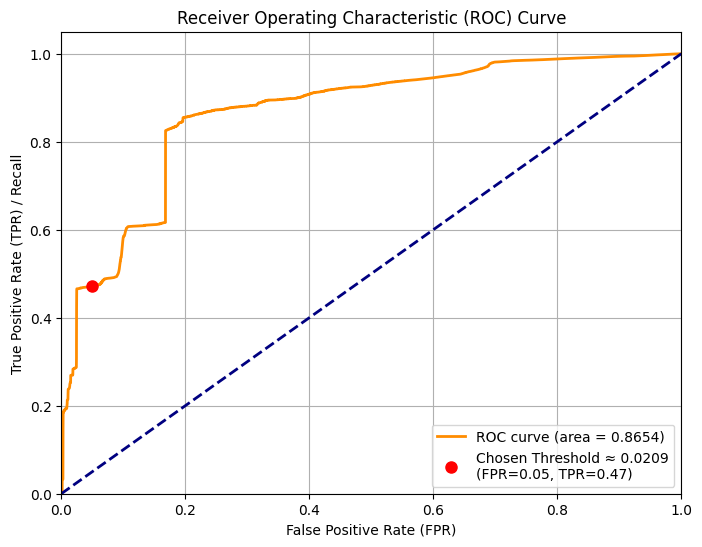

In [13]:
# ==================================================
# Cell 13: 計算分類評估指標 (F1, Precision, Recall, Accuracy, AUC)
# ==================================================
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

print("\n==================== 計算分類評估指標 ====================")

# --- 1. 準備數據 ---
# 檢查是否有 Benign 和 Non-Benign 的評估結果
if 'benign_test_losses' not in locals() or not non_benign_results:
    print("錯誤：缺少 Benign 或 Non-Benign 的測試誤差數據，無法計算分類指標。")
    print("請確保 Cell 9 和 Cell 11 已成功執行。")
else:
    # 組合所有 Non-Benign 檔案的誤差
    all_non_benign_losses = []
    for filename, loader in non_benign_loaders.items():
        print(f"  從檔案收集 Non-Benign 誤差: {filename}")
        # (需要重新計算或儲存 Cell 11 的 non_benign_test_losses 列表)
        # 為了簡化，我們重新計算一次 Non-Benign 誤差 (如果記憶體允許)
        # 如果記憶體不足，您需要在 Cell 11 中將 non_benign_test_losses 存儲到 non_benign_results 字典中
        current_non_benign_losses = []
        model.eval() # 確保模型在評估模式
        with torch.no_grad():
            for batch_features, _ in loader:
                batch_features = batch_features.to(device)
                outputs = model(batch_features)
                loss = nn.MSELoss(reduction='none')(outputs, batch_features).mean(dim=1)
                current_non_benign_losses.extend(loss.cpu().numpy())
        all_non_benign_losses.extend(current_non_benign_losses)
        print(f"    收集到 {len(current_non_benign_losses)} 筆誤差。")

    if not all_non_benign_losses:
        print("錯誤：未能從 Non-Benign 檔案中收集到任何誤差數據。")
    else:
        # 合併所有誤差：Benign 誤差 + Non-Benign 誤差
        all_losses = np.concatenate([benign_test_losses, all_non_benign_losses])

        # 創建對應的真實標籤
        # 假設 Benign 為 0 (正常), Non-Benign 為 1 (異常)
        true_labels_benign = np.zeros(len(benign_test_losses))
        true_labels_non_benign = np.ones(len(all_non_benign_losses))
        all_true_labels = np.concatenate([true_labels_benign, true_labels_non_benign])

        print(f"\n數據準備完成:")
        print(f"  總樣本數: {len(all_losses)}")
        print(f"  正常樣本 (標籤 0) 數量: {len(true_labels_benign)}")
        print(f"  異常樣本 (標籤 1) 數量: {len(true_labels_non_benign)}")

        # --- 2. 選擇閾值 ---
        # 使用 Benign 測試集誤差的特定分位數作為閾值
        # 例如，選擇第 95 個百分位數
        percentile_q = 95 # *** 可調整的分位數 (例如 90, 95, 99) ***
        threshold = np.percentile(benign_test_losses, percentile_q)
        print(f"\n選擇閾值策略: 基於 Benign 數據的第 {percentile_q} 百分位數")
        print(f"計算出的閾值 (Threshold): {threshold:.6f}")
        print(f"(意義：大約 {100-percentile_q}% 的 Benign 樣本誤差會高於此閾值，可能被誤判)")

        # --- 3. 產生預測標籤 ---
        # 重建誤差 > 閾值 => 預測為 1 (異常)
        # 重建誤差 <= 閾值 => 預測為 0 (正常)
        predicted_labels = (all_losses > threshold).astype(int)

        # --- 4. 計算評估指標 ---
        print("\n--- 評估指標 (基於選定閾值) ---")

        # 計算 Accuracy
        accuracy = accuracy_score(all_true_labels, predicted_labels)
        print(f"Accuracy (準確率): {accuracy:.4f}")

        # 計算 Precision, Recall, F1-Score (針對異常類別，即標籤 1)
        # zero_division=0: 如果分母為0 (例如沒有預測出正類)，則指標設為0
        precision = precision_score(all_true_labels, predicted_labels, pos_label=1, zero_division=0)
        recall = recall_score(all_true_labels, predicted_labels, pos_label=1, zero_division=0)
        f1 = f1_score(all_true_labels, predicted_labels, pos_label=1, zero_division=0)
        print(f"Precision (異常類 精確率): {precision:.4f}")
        print(f"Recall (異常類 召回率/敏感度): {recall:.4f}")
        print(f"F1-Score (異常類 F1分數): {f1:.4f}")

        # 顯示詳細的分類報告
        print("\nClassification Report:")
        # target_names 可以自訂標籤名稱
        print(classification_report(all_true_labels, predicted_labels, target_names=['Benign (0)', 'Anomaly (1)'], zero_division=0))

        # 顯示混淆矩陣
        print("Confusion Matrix:")
        # TN FP
        # FN TP
        cm = confusion_matrix(all_true_labels, predicted_labels)
        print(cm)
        tn, fp, fn, tp = cm.ravel()
        print(f"  True Negatives (TN) - 正確預測為 Benign: {tn}")
        print(f"  False Positives (FP) - 錯誤預測為 Anomaly (Type I Error): {fp}")
        print(f"  False Negatives (FN) - 錯誤預測為 Benign (Type II Error): {fn}")
        print(f"  True Positives (TP) - 正確預測為 Anomaly: {tp}")

        # --- 5. 計算 ROC AUC (不依賴特定閾值) ---
        print("\n--- ROC 曲線與 AUC ---")
        # 計算 ROC 曲線的點 (fpr, tpr)
        # 注意：roc_curve 的輸入是真實標籤和 '預測為正類的概率或分數'，這裡我們用重建誤差 (越高越可能是異常)
        fpr, tpr, thresholds_roc = roc_curve(all_true_labels, all_losses, pos_label=1)
        # 計算 AUC (Area Under the Curve)
        roc_auc = auc(fpr, tpr)
        print(f"AUC (Area Under ROC Curve): {roc_auc:.4f}")
        print("(AUC 越接近 1，表示模型在區分兩個類別上的整體性能越好)")

        # 繪製 ROC 曲線
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # 對角線 (隨機猜測)
        # 標記我們選擇的閾值對應的點 (近似)
        idx = np.argmin(np.abs(thresholds_roc - threshold)) # 找到最接近我們閾值的點
        plt.plot(fpr[idx], tpr[idx], 'ro', markersize=8, label=f'Chosen Threshold ≈ {threshold:.4f}\n(FPR={fpr[idx]:.2f}, TPR={tpr[idx]:.2f})')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR) / Recall')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

# 清理可能的大型陣列 (如果需要)
# del all_losses, all_true_labels, predicted_labels, benign_test_losses, all_non_benign_losses
# if manual_garbage_collection: gc.collect()

**使用說明：**

1.  **環境設定：** 確保您已安裝必要的 Python 函式庫：`torch`, `pandas`, `numpy`, `scikit-learn`。如果未安裝，可以使用 `pip install torch pandas numpy scikit-learn` 來安裝。
2.  **建立 Notebook：** 打開 Jupyter Notebook 或 Jupyter Lab。
3.  **複製貼上：** 將上面標示為 `Cell 1`, `Cell 2`, ... 的程式碼區塊，分別複製到 Notebook 的不同儲存格中。
4.  **修改設定 (重要!)：**
    * **Cell 2:**
        * 修改 `input_csv_folder` 指向您存放原始 CSV 檔案的資料夾。
        * 修改 `output_folder` 設定您想要儲存處理後檔案的位置。
        * 確認 `label_column` 和 `benign_label_value` 與您的 CSV 檔案一致。
        * **仔細設定 `features_to_use` 列表，只包含您想要用於訓練模型的數值特徵欄位名稱。**
    * **Cell 6 & 7:** 您可以根據需要調整 Autoencoder 的架構 (`encoding_dim1`, `encoding_dim2`, `latent_dim`) 和訓練參數 (`learning_rate`, `num_epochs`, `batch_size`)。
    * **Cell 1:** 您可以設定 `downcast_numeric` 和 `manual_garbage_collection` 為 `True` 或 `False` 來啟用或禁用記憶體優化選項。
5.  **執行儲存格：** 按照順序依次執行 Notebook 中的每個儲存格。
6.  **觀察輸出：** 每個儲存格執行時會打印相關訊息，包括檔案處理進度、訓練損失、最終的評估分數等。
7.  **結果解讀：** 最後一個儲存格會提供結果摘要和基本的解讀，幫助您判斷模型的效果。

這個範本提供了一個完整的流程，您可以根據您的具體數據和需求進行修改和擴展。祝您訓練順利！

<div class="md-recitation">
  Sources
  <ol>
  <li><a href="https://aistudio.baidu.com/aistudio/projectdetail/1236018">https://aistudio.baidu.com/aistudio/projectdetail/1236018</a></li>
  <li><a href="https://stackoverflow.com/questions/78539311/packet-anomaly-detection-using-isolationforest">https://stackoverflow.com/questions/78539311/packet-anomaly-detection-using-isolationforest</a></li>
  <li><a href="https://www.kaggle.com/peterfriedrich1/cicdarknet2020-internet-traffic/metadata">https://www.kaggle.com/peterfriedrich1/cicdarknet2020-internet-traffic/metadata</a></li>
  <li><a href="https://github.com/GennadiyProg/layerZeroScripts">https://github.com/GennadiyProg/layerZeroScripts</a></li>
  </ol>
</div>